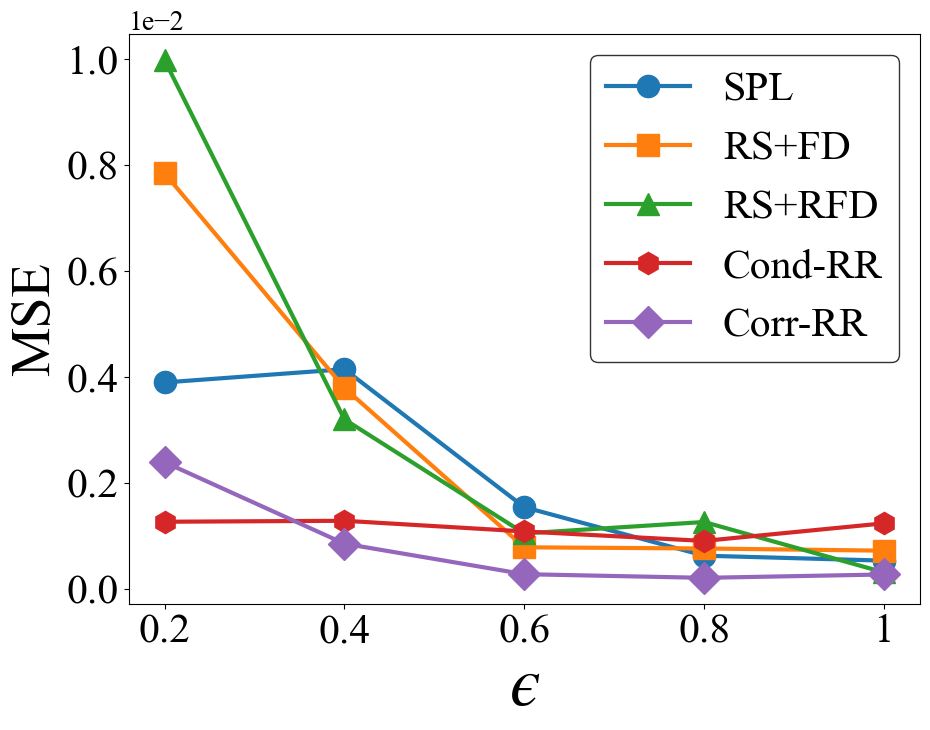

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib as mpl
import math
import os

# --- set global font to Times New Roman ---
mpl.rc('font', family='serif', serif=['Times New Roman'])
mpl.rcParams.update({
    'text.usetex': False,            # switch to True if you have a TeX installation
    'font.size': 16,                 # fallback for general text
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'figure.titlesize': 20,
})

# 💡 Use mathtext with LaTeX-like fonts (no need for usetex)
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.fontset'] = 'cm'  # Computer Modern
mpl.rcParams['font.family'] = 'serif'   # LaTeX-style serif fonts
mpl.rcParams['font.size'] = 30

from data_utils import correlated_data_generator, get_true_frequencies
from metrics import compute_mse

# mechanisms
from spl import random_split_perturb, random_split_estimate
from rs_fd import rs_fd_perturb, rs_fd_estimate
from rs_rfd import rs_rfd_perturb, rs_rfd_estimate

# Corr-RR pieces (use your minimal API; no build_p_y_table import)
from corr_rr import (
    corr_rr_phase1_spl,
    corr_rr_phase2_perturb,
    corr_rr_estimate,
    combine_phase_estimates,   # reused for RS+RFD two-phase combine too
    optimal_p_y,               # we'll build p_y table locally
)

# Cond-RR (binary, d=2) — use the combined estimator
from condrr import (
    condrr_perturb_binary,
    condrr_estimate_binary_combined,
)

# ---- helper for priors (normalize Phase I marginals) ----
def _normalize_dist(d):
    vals = np.array([max(0.0, float(v)) for v in d.values()], dtype=float)
    s = vals.sum()
    if s <= 0:
        k = len(vals)
        vals = np.full(k, 1.0 / k)
    else:
        vals = vals / s
    return {k: vals[i] for i, k in enumerate(d.keys())}

# ---- local helper to build p_y table using your optimal_p_y ----
def _build_p_y_table(est_I, epsilon, n2, domain, cols):
    """
    Build p_y[(a->b)] for all ordered pairs using your minimal optimal_p_y().
    `domain` should be the shared domain list (e.g., [0,1]).
    """
    return {
        (a, b): optimal_p_y(est_I[a], est_I[b], epsilon, n2, domain)
        for a in cols for b in cols if a != b
    }

# ---------------- run once ----------------
def run_all_once(
    df,
    epsilon,
    use_corr_rr=True,
    frac_phase1_corr=0.1,
    frac_phase1_rsrfd=0.1,   # Phase I fraction for RS+RFD (two-phase)
    frac_phase1_condrr=0.2,  # Phase I fraction for Cond-RR (binary)
):
    """
    Compute per-mechanism MSEs for one dataset at a given ε.
    RS+RFD is two-phase; Corr-RR optional; Cond-RR is binary (d=2) and two-phase (combined estimator).
    """
    cols = list(df.columns)
    domains = {c: sorted(df[c].unique().tolist()) for c in cols}
    true_freqs = get_true_frequencies(df, cols)

    out = {}

    # --- SPL (baseline) ---
    rpt = random_split_perturb(df, epsilon)
    est = random_split_estimate(rpt, df, epsilon)
    out["SPL"] = np.mean([compute_mse(true_freqs[c], est[c]) for c in cols])

    # --- RS+FD (baseline) ---
    pert_rsfd = rs_fd_perturb(df, domains, epsilon)
    est_rsfd = rs_fd_estimate(pert_rsfd, domains, epsilon)
    out["RS+FD"] = np.mean([compute_mse(true_freqs[c], est_rsfd[c]) for c in cols])

    # --- RS+RFD (TWO-PHASE) ---
    # Your corr_rr_phase1_spl returns (est_I, df_B) only — build domains map locally
    est_I_rsrfd, df_B_rsrfd = corr_rr_phase1_spl(df, epsilon, frac=frac_phase1_rsrfd)
    n1_rsrfd = len(df) - len(df_B_rsrfd)
    n2_rsrfd = len(df_B_rsrfd)
    doms_stable_rsrfd = {c: sorted(df[c].unique().tolist()) for c in df.columns}

    priors_2p = {col: _normalize_dist(est_I_rsrfd[col]) for col in est_I_rsrfd}

    pert_rsrfd_2p = rs_rfd_perturb(df_B_rsrfd, doms_stable_rsrfd, priors_2p, epsilon)
    est_II_rsrfd = rs_rfd_estimate(pert_rsrfd_2p, doms_stable_rsrfd, priors_2p, epsilon)

    combined_rsrfd = combine_phase_estimates(est_I_rsrfd, est_II_rsrfd, n1_rsrfd, n2_rsrfd)
    out["RS+RFD"] = np.mean([compute_mse(true_freqs[c], combined_rsrfd[c]) for c in cols])

    # --- Cond-RR (binary, d=2): two-phase combined estimator ---
    # Assumes df has exactly 2 binary attributes for this mechanism.
    if df.shape[1] >= 2:
        df2 = df[cols[:2]]
        reports_cond, pub_cond = condrr_perturb_binary(df2, epsilon, frac=frac_phase1_condrr)
        est_cond_combined = condrr_estimate_binary_combined(reports_cond, df2, epsilon, pub_cond)
        out["Cond-RR"] = np.mean([
            compute_mse(get_true_frequencies(df2, cols[:2])[c], est_cond_combined[c])
            for c in cols[:2]
        ])

    # --- Corr-RR (optional, using your minimal API) ---
    if use_corr_rr:
        # Phase I
        est_I, df_B = corr_rr_phase1_spl(df, epsilon, frac=frac_phase1_corr)
        n1 = len(df) - len(df_B)
        n2 = len(df_B)

        # Domains map from the ORIGINAL df (keeps ordering stable)
        doms_stable = {c: sorted(df[c].unique().tolist()) for c in cols}
        common_domain = doms_stable[cols[0]]  # assumes common domain ([0,1] in your generator)

        # Build p_y table locally
        p_y_table = _build_p_y_table(est_I, epsilon, n2, common_domain, cols)

        # Phase II generation (signature expects f_hat_phase1; pass est_I even if unused)
        pert_corr = corr_rr_phase2_perturb(df_B, epsilon, est_I, doms_stable, p_y_table)

        # Estimation: minimal signature (no p_y_table)
        est_II = corr_rr_estimate(pert_corr, doms_stable, epsilon)

        # Combine
        combined_est = combine_phase_estimates(est_I, est_II, n1, n2)
        out["Corr-RR"] = np.mean([compute_mse(true_freqs[c], combined_est[c]) for c in cols])

    return out


def sweep_all(
    n=10000,
    epsilons=(0.2, 0.4, 0.6, 0.8, 1.0),
    R=50,
    corr=0.9,
    plot_dir=None,               # directory to save the PDF
    csv_dir=None,                # directory to save the CSV
    seed=None,
    use_corr_rr=True,
    frac_phase1_corr=0.1,
    frac_phase1_rsrfd=0.1,       # RS+RFD (two-phase)
    frac_phase1_condrr=0.2,      # Cond-RR (binary)
):
    """
    Run R independent trials for each ε, average MSEs, and plot.
    RS+RFD is the TWO-PHASE variant only.
    Corr-RR optional. Cond-RR added for d=2 binary.
    Saves a PDF plot and a CSV of the averaged means if directories are provided.
    """
    domain = [0, 1]
    correlations = [('X1', 'X2', corr)]
    keys = ["SPL", "RS+FD", "RS+RFD", "Cond-RR"] + (["Corr-RR"] if use_corr_rr else [])
    means = {k: np.zeros(len(epsilons)) for k in keys}

    if seed is not None:
        np.random.seed(seed)

    attr_count = None  # will infer from first generated df
    domain_size = len(domain)

    for run in range(R):
        # fresh dataset each run (binary d=2 works for all mechanisms here)
        df = correlated_data_generator(
            domain,
            n=n,
            correlations=correlations,
            total_attributes=2,
            seed=None
        )
        if attr_count is None:
            attr_count = df.shape[1]

        for j, eps in enumerate(epsilons):
            res = run_all_once(
                df,
                eps,
                use_corr_rr=use_corr_rr,
                frac_phase1_corr=frac_phase1_corr,
                frac_phase1_rsrfd=frac_phase1_rsrfd,
                frac_phase1_condrr=frac_phase1_condrr,
            )
            for k in keys:
                means[k][j] += res[k]

    for k in keys:
        means[k] /= R

    # --- Plot ---
    plt.figure(figsize=(10, 8))
    plt.plot(epsilons, means["SPL"],       '-o', linewidth=3, markersize=16, label='SPL')
    plt.plot(epsilons, means["RS+FD"],     '-s', linewidth=3, markersize=16, label='RS+FD')
    plt.plot(epsilons, means["RS+RFD"],    '-^', linewidth=3, markersize=16, label='RS+RFD')
    plt.plot(epsilons, means["Cond-RR"],   '-h', linewidth=3, markersize=16, label='Cond-RR')
    if use_corr_rr:
        plt.plot(epsilons, means["Corr-RR"], '-D', linewidth=3, markersize=16, label='Corr-RR')

    plt.xlabel(r'$ϵ$', fontsize=50)
    plt.ylabel('MSE',  fontsize=40)
    plt.xticks(epsilons, labels=[str(e) for e in epsilons])
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    plt.legend(fontsize=30, loc='upper right', frameon=True, edgecolor='black')
    plt.tight_layout()

    # --- Build dynamic filename pieces ---
    def _fmt(x):  # compact float formatting (e.g., 0.2, 0.9, 1, 2)
        return f"{x:g}"

    # choose a single frac for naming: if equal, use that; else fall back to rsrfd fraction
    fracs = {frac_phase1_corr, frac_phase1_rsrfd, frac_phase1_condrr}
    if len(fracs) == 1:
        frac_for_name = fracs.pop()
    else:
        frac_for_name = frac_phase1_rsrfd

    base = f"mseVSepsilon_{attr_count}attribute_{domain_size}domain_n_{n}_frac_{_fmt(frac_for_name)}_corr_{_fmt(corr)}"

    # Save PDF plot
    if plot_dir:
        os.makedirs(plot_dir, exist_ok=True)
        pdf_path = os.path.join(plot_dir, base + ".pdf")
        plt.savefig(pdf_path, format="pdf")

    plt.show()

    # Save CSV of averaged means
    if csv_dir:
        os.makedirs(csv_dir, exist_ok=True)
        df_out = pd.DataFrame({"epsilon": list(epsilons)})
        for k in keys:
            df_out[k] = means[k]
        csv_path = os.path.join(csv_dir, base + ".csv")
        df_out.to_csv(csv_path, index=False)

    return means


if __name__ == "__main__":
    eps = [0.2, 0.4, 0.6, 0.8, 1]
    means = sweep_all(
        n=10000, epsilons=eps, R=5, corr=0.2,
        seed=42, use_corr_rr=True,
        frac_phase1_corr=0.2, frac_phase1_rsrfd=0.2, frac_phase1_condrr=0.2,
        # plot_dir="C:/Users/ss6365/Desktop/pets_plots",          # your directory for PDFs
        # csv_dir="C:/Users/ss6365/Desktop/pets_plots/data"       # your directory for CSVs
    )


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib as mpl
import math
import os

# --- set global font to Times New Roman ---
mpl.rc('font', family='serif', serif=['Times New Roman'])
mpl.rcParams.update({
    'text.usetex': False,            # switch to True if you have a TeX installation
    'font.size': 16,                 # fallback for general text
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'figure.titlesize': 20,
})

# 💡 Use mathtext with LaTeX-like fonts (no need for usetex)
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.fontset'] = 'cm'  # Computer Modern
mpl.rcParams['font.family'] = 'serif'   # LaTeX-style serif fonts
mpl.rcParams['font.size'] = 30

from data_utils import correlated_data_generator, get_true_frequencies
from metrics import compute_mse

# mechanisms
from spl import random_split_perturb, random_split_estimate
from rs_fd import rs_fd_perturb, rs_fd_estimate
from rs_rfd import rs_rfd_perturb, rs_rfd_estimate

# Corr-RR pieces (use your minimal API; no build_p_y_table import)
from corr_rr import (
    corr_rr_phase1_spl,
    corr_rr_phase2_perturb,
    corr_rr_estimate,
    combine_phase_estimates,   # reused for RS+RFD two-phase combine too
    optimal_p_y,               # we'll build p_y table locally
)

# Cond-RR (binary, d=2) — use the combined estimator
from condrr import (
    condrr_perturb_binary,
    condrr_estimate_binary_combined,
)

# ---- helper for priors (normalize Phase I marginals) ----
def _normalize_dist(d):
    vals = np.array([max(0.0, float(v)) for v in d.values()], dtype=float)
    s = vals.sum()
    if s <= 0:
        k = len(vals)
        vals = np.full(k, 1.0 / k)
    else:
        vals = vals / s
    return {k: vals[i] for i, k in enumerate(d.keys())}

# ---- local helper to build p_y table using your optimal_p_y ----
def _build_p_y_table(est_I, epsilon, n2, domain, cols):
    """
    Build p_y[(a->b)] for all ordered pairs using your minimal optimal_p_y().
    `domain` should be the shared domain list (e.g., [0,1]).
    """
    return {
        (a, b): optimal_p_y(est_I[a], est_I[b], epsilon, n2, domain)
        for a in cols for b in cols if a != b
    }

# ---------------- run once ----------------
def run_all_once(
    df,
    epsilon,
    use_corr_rr=True,
    frac_phase1_corr=0.1,
    frac_phase1_rsrfd=0.1,   # Phase I fraction for RS+RFD (two-phase)
    frac_phase1_condrr=0.2,  # Phase I fraction for Cond-RR (binary)
):
    """
    Compute per-mechanism MSEs for one dataset at a given ε.
    RS+RFD is two-phase; Corr-RR optional; Cond-RR is binary (d=2) and two-phase (combined estimator).
    """
    cols = list(df.columns)
    domains = {c: sorted(df[c].unique().tolist()) for c in cols}
    true_freqs = get_true_frequencies(df, cols)

    out = {}

    # --- SPL (baseline) ---
    rpt = random_split_perturb(df, epsilon)
    est = random_split_estimate(rpt, df, epsilon)
    out["SPL"] = np.mean([compute_mse(true_freqs[c], est[c]) for c in cols])

    # --- RS+FD (baseline) ---
    pert_rsfd = rs_fd_perturb(df, domains, epsilon)
    est_rsfd = rs_fd_estimate(pert_rsfd, domains, epsilon)
    out["RS+FD"] = np.mean([compute_mse(true_freqs[c], est_rsfd[c]) for c in cols])

    # --- RS+RFD (TWO-PHASE) ---
    # Your corr_rr_phase1_spl returns (est_I, df_B) only — build domains map locally
    est_I_rsrfd, df_B_rsrfd = corr_rr_phase1_spl(df, epsilon, frac=frac_phase1_rsrfd)
    n1_rsrfd = len(df) - len(df_B_rsrfd)
    n2_rsrfd = len(df_B_rsrfd)
    doms_stable_rsrfd = {c: sorted(df[c].unique().tolist()) for c in df.columns}

    priors_2p = {col: _normalize_dist(est_I_rsrfd[col]) for col in est_I_rsrfd}

    pert_rsrfd_2p = rs_rfd_perturb(df_B_rsrfd, doms_stable_rsrfd, priors_2p, epsilon)
    est_II_rsrfd = rs_rfd_estimate(pert_rsrfd_2p, doms_stable_rsrfd, priors_2p, epsilon)

    combined_rsrfd = combine_phase_estimates(est_I_rsrfd, est_II_rsrfd, n1_rsrfd, n2_rsrfd)
    out["RS+RFD"] = np.mean([compute_mse(true_freqs[c], combined_rsrfd[c]) for c in cols])

    # --- Cond-RR (binary, d=2): two-phase combined estimator ---
    # Assumes df has exactly 2 binary attributes for this mechanism.
    if df.shape[1] >= 2:
        df2 = df[cols[:2]]
        reports_cond, pub_cond = condrr_perturb_binary(df2, epsilon, frac=frac_phase1_condrr)
        est_cond_combined = condrr_estimate_binary_combined(reports_cond, df2, epsilon, pub_cond)
        out["Cond-RR"] = np.mean([
            compute_mse(get_true_frequencies(df2, cols[:2])[c], est_cond_combined[c])
            for c in cols[:2]
        ])

    # --- Corr-RR (optional, using your minimal API) ---
    if use_corr_rr:
        # Phase I
        est_I, df_B = corr_rr_phase1_spl(df, epsilon, frac=frac_phase1_corr)
        n1 = len(df) - len(df_B)
        n2 = len(df_B)

        # Domains map from the ORIGINAL df (keeps ordering stable)
        doms_stable = {c: sorted(df[c].unique().tolist()) for c in cols}
        common_domain = doms_stable[cols[0]]  # assumes common domain ([0,1] in your generator)

        # Build p_y table locally
        p_y_table = _build_p_y_table(est_I, epsilon, n2, common_domain, cols)

        # Phase II generation (signature expects f_hat_phase1; pass est_I even if unused)
        pert_corr = corr_rr_phase2_perturb(df_B, epsilon, est_I, doms_stable, p_y_table)

        # Estimation: minimal signature (no p_y_table)
        est_II = corr_rr_estimate(pert_corr, doms_stable, epsilon)

        # Combine
        combined_est = combine_phase_estimates(est_I, est_II, n1, n2)
        out["Corr-RR"] = np.mean([compute_mse(true_freqs[c], combined_est[c]) for c in cols])

    return out


def sweep_all(
    n=10000,
    epsilons=(0.2, 0.4, 0.6, 0.8, 1.0),
    R=50,
    corr=0.9,
    plot_dir=None,               # directory to save the PDF
    csv_dir=None,                # directory to save the CSV
    seed=None,
    use_corr_rr=True,
    frac_phase1_corr=0.1,
    frac_phase1_rsrfd=0.1,       # RS+RFD (two-phase)
    frac_phase1_condrr=0.2,      # Cond-RR (binary)
):
    """
    Run R independent trials for each ε, average MSEs, and plot.
    RS+RFD is the TWO-PHASE variant only.
    Corr-RR optional. Cond-RR added for d=2 binary.
    Saves a PDF plot and a CSV of the averaged means if directories are provided.
    """
    domain = [0, 1]
    correlations = [('X1', 'X2', corr)]
    keys = ["SPL", "RS+FD", "RS+RFD", "Cond-RR"] + (["Corr-RR"] if use_corr_rr else [])
    means = {k: np.zeros(len(epsilons)) for k in keys}

    if seed is not None:
        np.random.seed(seed)

    attr_count = None  # will infer from first generated df
    domain_size = len(domain)

    for run in range(R):
        # fresh dataset each run (binary d=2 works for all mechanisms here)
        df = correlated_data_generator(
            domain,
            n=n,
            correlations=correlations,
            total_attributes=2,
            seed=None
        )
        if attr_count is None:
            attr_count = df.shape[1]

        for j, eps in enumerate(epsilons):
            res = run_all_once(
                df,
                eps,
                use_corr_rr=use_corr_rr,
                frac_phase1_corr=frac_phase1_corr,
                frac_phase1_rsrfd=frac_phase1_rsrfd,
                frac_phase1_condrr=frac_phase1_condrr,
            )
            for k in keys:
                means[k][j] += res[k]

    for k in keys:
        means[k] /= R

    # --- Plot ---
    plt.figure(figsize=(10, 8))
    plt.plot(epsilons, means["SPL"],       '-o', linewidth=3, markersize=16, label='SPL')
    plt.plot(epsilons, means["RS+FD"],     '-s', linewidth=3, markersize=16, label='RS+FD')
    plt.plot(epsilons, means["RS+RFD"],    '-^', linewidth=3, markersize=16, label='RS+RFD')
    if use_corr_rr:
        plt.plot(epsilons, means["Corr-RR"], '-D', linewidth=3, markersize=16, label='Corr-RR')
    plt.plot(epsilons, means["Cond-RR"],   '-h', linewidth=3, markersize=16, label='Cond-RR')
    

    plt.xlabel(r'$ϵ$', fontsize=50)
    plt.ylabel('MSE',  fontsize=40)
    plt.xticks(epsilons, labels=[str(e) for e in epsilons])
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    plt.legend(fontsize=30, loc='upper right', frameon=True, edgecolor='black')
    plt.tight_layout()

    # --- Build dynamic filename pieces ---
    def _fmt(x):  # compact float formatting (e.g., 0.2, 0.9, 1, 2)
        return f"{x:g}"

    # choose a single frac for naming: if equal, use that; else fall back to rsrfd fraction
    fracs = {frac_phase1_corr, frac_phase1_rsrfd, frac_phase1_condrr}
    if len(fracs) == 1:
        frac_for_name = fracs.pop()
    else:
        frac_for_name = frac_phase1_rsrfd

    base = f"mseVSepsilon_{attr_count}attribute_{domain_size}domain_n_{n}_frac_{_fmt(frac_for_name)}_corr_{_fmt(corr)}"

    # Save PDF plot
    if plot_dir:
        os.makedirs(plot_dir, exist_ok=True)
        pdf_path = os.path.join(plot_dir, base + ".pdf")
        plt.savefig(pdf_path, format="pdf")

    plt.show()

    # Save CSV of averaged means
    if csv_dir:
        os.makedirs(csv_dir, exist_ok=True)
        df_out = pd.DataFrame({"epsilon": list(epsilons)})
        for k in keys:
            df_out[k] = means[k]
        csv_path = os.path.join(csv_dir, base + ".csv")
        df_out.to_csv(csv_path, index=False)

    return means


if __name__ == "__main__":
    eps = [0.2, 0.4, 0.6, 0.8, 1]
    means = sweep_all(
        n=2000, epsilons=eps, R=40, corr=0.9,
        seed=42, use_corr_rr=True,
        frac_phase1_corr=0.2, frac_phase1_rsrfd=0.2, frac_phase1_condrr=0.2,
        # plot_dir="C:/Users/ss6365/Desktop/pets_plots",          # your directory for PDFs
        # csv_dir="C:/Users/ss6365/Desktop/pets_plots/data"       # your directory for CSVs
    )
